<a href="https://colab.research.google.com/github/esthy13/AI-CDMO-LAB/blob/main/Water_level_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water level prediction using ERA5

The problem consists in predicting the level of the water in the north adriatic sea, mainly relying on position (lat, lon), ephemeridis of moon and sun (for tides), wind and pressure (for storm surge).

Given a set of 5,000 nodes over the Northern Adriatic Sea, defined by varying longitude and latitude, you are supposed to infer the water level of these points at each hour in a given range, using a neural network.

You have at you disposal 9 years of hourly data for training your model.

A detailed description of the problem and instructions for dowloading and interpreting data are provided in the companion notebook

## Problem description
Given a set of  5,000  nodes over the Northern Adriatic Sea, defined by varying longitude and latitude (visualized as red spots in image below), you are supposed to infer the water level of these points at each hour in a given range, using a neural network.

In [1]:
#import base64
#from IPython.display import HTML, display

#with open("graphical_visualization.png", "rb") as f:
#    encoded = base64.b64encode(f.read()).decode("utf-8")
#
#display(HTML(f"""<img src="data:image/png;base64,{encoded}" width="800"/>"""))

The information you can use to predict these values are:
* **latitude** and **longitude** of the nodes
* the **ephemerides** relative to the sun and the moon at each hour (we consider a single value of the ephemeridies for the whole region). Ephemerides are key predictors of tidal motion and are therefore important for the prediction of water level. The provided values of the ephemerides are already normalized.
* **weather variables** (wind components and pressure) derived from ERA5 dataset (not normalized). Due to the low resolution of ERA5, these values are organized as an array of shape $5 \times 9$ for each hour and each variable. A supporting function is provided to convert a given (latitude, longitude) of a node to the associated index of ERA5 array. Weather variables are important to predict phenomenon such as storm surge: another key component of water level.

For the prediction of the water level at timestamp $t$, you are allowed to use a sequence of any length of the input variables relative to past timesteps, but no future information. The output variable (corresponding to the **water level**) **CANNOT** be used as input to the model, not even for past timestamps.   


# Installing and importing useful libraries

In [2]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 43.8 MB/s eta 0:00:00


In [3]:
import gdown
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.dates as mdates
import IPython
import IPython.display
import os

In [4]:
os.environ["KERAS_BACKEND"] = "tensorflow"
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Download

In [5]:
!gdown 1NzYayIEoY_JzW9E-38ejnHahNlALlFBn
!gdown 1viecawNSkSEGUvEk7nu7rhKcRd5Q7wgm
!gdown 1aBCiXHEWN7ZeIlyj77qNCZ7DHwCUy9LG
!gdown 19m4hBBrup_Ast_ozGFDmVK-i7N2DUQC5
!gdown 1wtRof_MQJlE2GNplfbflAPR3cxpmiCeZ
!gdown 13q1PVFDcOTujx_r4fMPKxkJeMw4fAt5j
!gdown 1wVmxNvCg6Pe9Ol3LGM1NykXVwJiZUdE4
!gdown 1osjH0XjabPwZNuN8hKK1TcIvQ63Cfyda
!gdown 1epCvAsWYrCISdcbc2dXZArow5ouhsWjl
!gdown 1-ZrQDQcID40RBVSGAHqLTN0P_wr2U6_Q

Downloading...
From (original): https://drive.google.com/uc?id=1NzYayIEoY_JzW9E-38ejnHahNlALlFBn
From (redirected): https://drive.google.com/uc?id=1NzYayIEoY_JzW9E-38ejnHahNlALlFBn&confirm=t&uuid=2bc12d48-5e2a-4c58-9f09-ed4465568b3c
To: /content/wl_2020.npy
100% 176M/176M [00:04<00:00, 36.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1viecawNSkSEGUvEk7nu7rhKcRd5Q7wgm
From (redirected): https://drive.google.com/uc?id=1viecawNSkSEGUvEk7nu7rhKcRd5Q7wgm&confirm=t&uuid=0db22e32-2a35-49e6-ad18-f0cf476078ff
To: /content/wl_2010-2020.npy
100% 1.75G/1.75G [00:33<00:00, 52.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aBCiXHEWN7ZeIlyj77qNCZ7DHwCUy9LG
To: /content/tvec_2010-2019.npy
100% 4.21M/4.21M [00:00<00:00, 12.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=19m4hBBrup_Ast_ozGFDmVK-i7N2DUQC5
To: /content/lon.npy
100% 20.1k/20.1k [00:00<00:00, 54.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wtRof_MQJlE2GNplfbflAPR3cxpmiCeZ
To: /c

## File description

Spatial coordinates

`lat.npy`
- latitudes of the 5000 target nodes,
- shape (5'000,)

`lon.npy` :
- longitudes of the 5000 target nodes
- shape (5'000,)

## Training data

hourly values from 01/01/2010 until 31/12/2019 (87648 hours)

`wl_2010-2019.npy`
- Water level measurements.
- Shape: (87'648, 5'000)

`dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy`
- Ephemerides features
- Shape: (6, 87'648)

`ERA5_adriatic_u10v10sp_2010-2019.npy`
- ERA5 predictors (variables, timestamps, x , y)
- Shape: (3, 87'648, 5, 9)

`tvec_2010-2019.npy`
- Explicit time information
- Shape: (87'648)

## Test data

hourly values from 01/01/2020 until 31/12/2020 (8784 hours)

`wl_2020.npy`
- Water level measurements, Shape: (8'784, 5'000)

`dist_alt_az_moon-sun_coord13-45_2020_norm.npy`
- Ephemerides features
- Shape: (6, 8'784)

`ERA5_adriatic_u10v10sp_2020.npy`
- ERA5 predictors (variables, timestamps, x , y)
- Shape: (3, 8'784, 5, 9)

`tvec_2020.npy`
- Explicit time information
- Shape: (8'784)

In [54]:
# load nodes coordinates
lat_vec = np.load("./lat.npy") # (5000, )
lon_vec = np.load("./lon.npy") # (5000, )

#load train data
train_wl = np.load("./wl_2010-2020.npy") # (87648, 5000)
train_ephem = np.load("./dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy") # (6, 87648)
train_era5 = np.load("./ERA5_adriatic_u10v10sp_2010-2019.npy") # (3, 87648, 5, 9)
train_tvec = np.load("./tvec_2010-2019.npy") # (6, 87648))

#load test data
test_wl = np.load("./wl_2020.npy") # (8784, 5000)
test_ephem = np.load("./dist_alt_az_moon-sun_coord13-45_2020_norm.npy") # (6, 8784)
test_era5 = np.load("./ERA5_adriatic_u10v10sp_2020.npy")#(3, 8784, 5, 9)
test_tvec = np.load("./tvec_2020.npy") # (6,8784)

## Data description

**ERA5:**
- Gridded, hourly atmospheric data
- Spatial resolution: $5 \times 9$ grid over the study area
- 3 variables: u10, v10 (10m wind components), surface pressure
- explicit time: Year,Month,Day,Hour,Minute,Second

**EPHEMERIDES:**
- 6 scalar features describing Moon–Sun geometry
  (e.g. distance, altitude, azimuth)
- Hourly resolution
- Spatially constant (same values for all target nodes)

**TARGET:**
- Water level at 5000 spatial nodes in the Northern Adriatic
- Each node has fixed latitude and longitude
- A function is provided to match node coordinates to the closest era5 data



In [55]:
# utilities functions
def get_era5_coord(lat, lon):
    """
    Function to get era5 data from data coordinates
    """
    era5_row, era5_col = 5, 9
    lat_min, lat_max = 44.94972, 45.8
    lon_min, lon_max = 12.12863, 13.81283

    delta_lat = lat_max - lat_min
    delta_lon = lon_max - lon_min

    lon_coord = np.ceil((lon - lon_min) / delta_lon * (era5_col -1))
    lat_coord = 4 - np.ceil((lat - lat_min) / delta_lat * (era5_row - 1))

    return int(lat_coord), int(lon_coord)

def RMSE(wl_true, wl_pred):
    """
    Root mean squared error
    """
    return np.sqrt(np.mean(np.square(wl_pred - wl_true)))

In [56]:
#example of usage of get_era5_coord
node_number = np.random.randint(np.shape(test_wl)[1])
era5_coords = get_era5_coord(lat_vec[node_number], lon_vec[node_number])
print(f"ERA5 grid coords for node {node_number}: {era5_coords}")
hour = np.random.randint(np.shape(test_wl)[1])
print(test_tvec[:,hour])
hour_time = datetime(*test_tvec[:,hour].astype(int))
print(hour_time)
wind0,wind1,pression = test_era5[:,hour,era5_coords[0],era5_coords[1]]
print(f"node {node_number} at time {hour_time} (no {hour}): wind0 = {wind0:.3f}, wind1 = {wind1:1.3f}, pression ={pression:.3f}")

ERA5 grid coords for node 913: (0, 6)
[2020.    4.    4.    6.    0.    0.]
2020-04-04 06:00:00
node 913 at time 2020-04-04 06:00:00 (no 2262): wind0 = -2.118, wind1 = -1.626, pression =98648.250


# Data Analysis

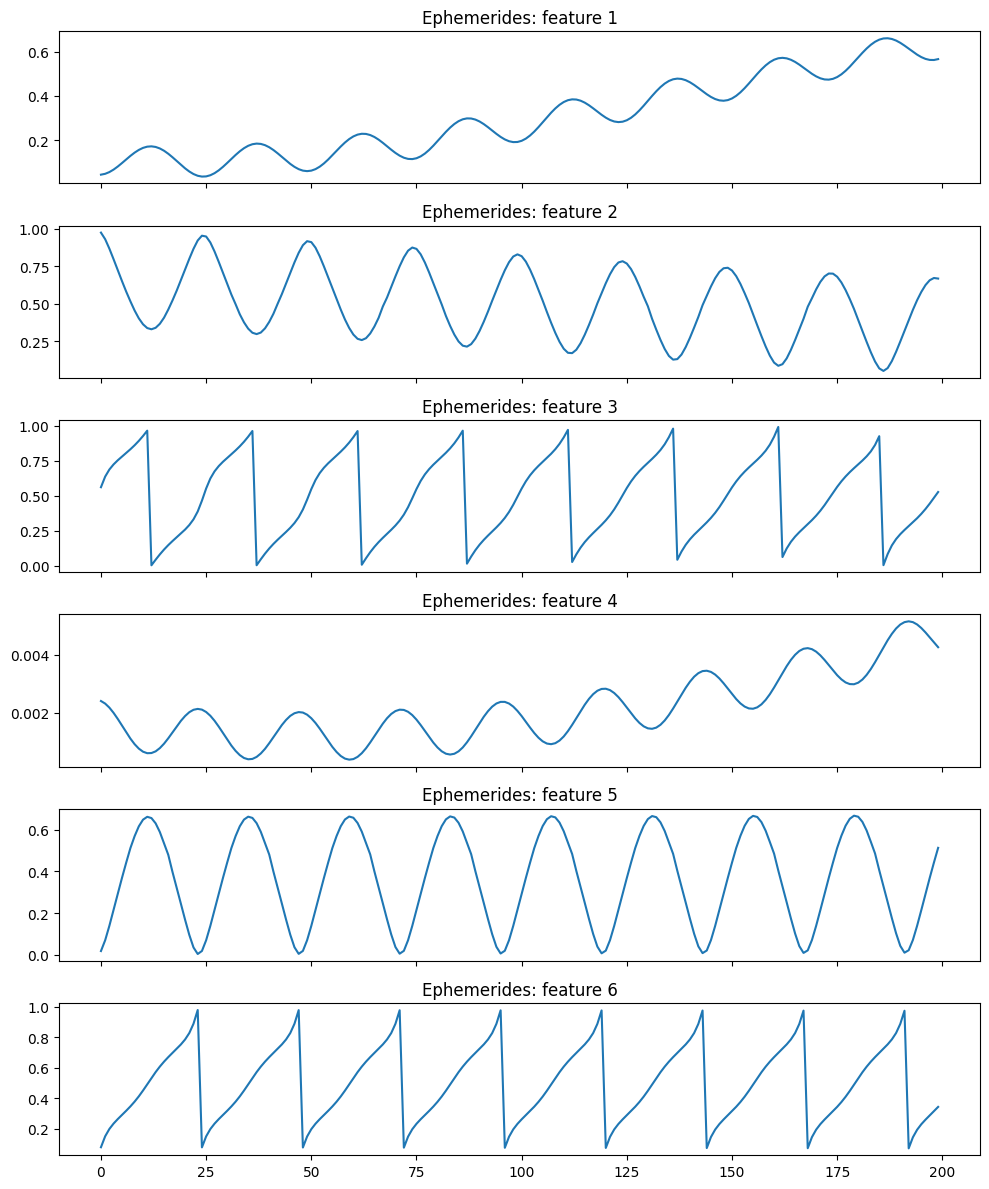

In [57]:
fig, axes = plt.subplots(6, 1, figsize=(10, 12), sharex=True)

for i in range(6):
    axes[i].plot(train_ephem[i, :200])
    axes[i].set_title(f"Ephemerides: feature {i+1}")
plt.tight_layout()
plt.show()

Ephemerides values are normalized as they lay between 0 and 1

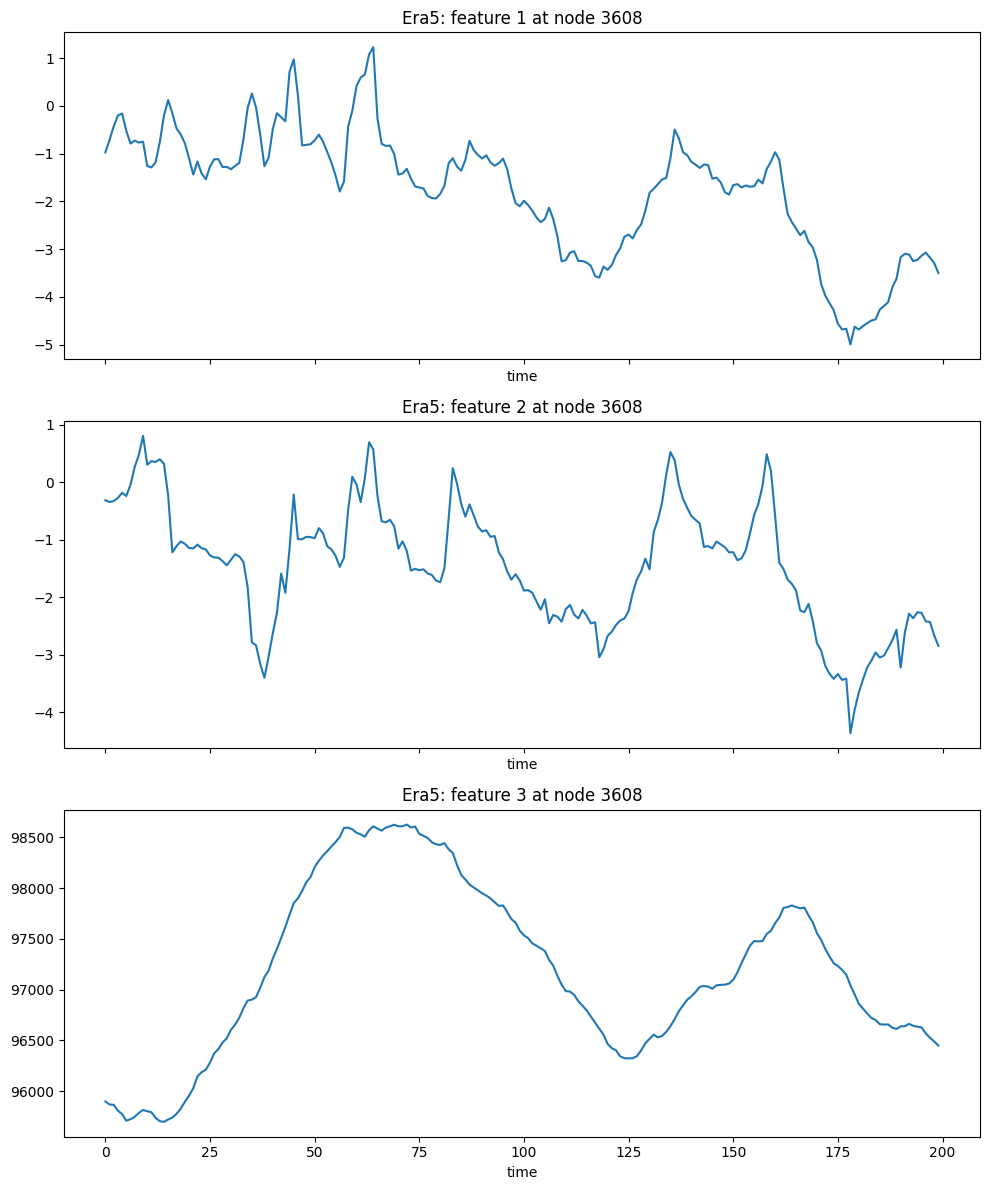

In [58]:
node_number = np.random.randint(np.shape(train_wl)[1])
era5_coords = get_era5_coord(lat_vec[node_number], lon_vec[node_number])

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i in range(3):
    axes[i].plot(train_era5[i, :200, era5_coords[0], era5_coords[1]])
    axes[i].set_title(f"Era5: feature {i+1} at node {node_number}")
    axes[i].set_xlabel("time")
plt.tight_layout()
plt.show()

As you may observe, wind and especially pressure **are not normalized!!** Era5 features need to be normalised

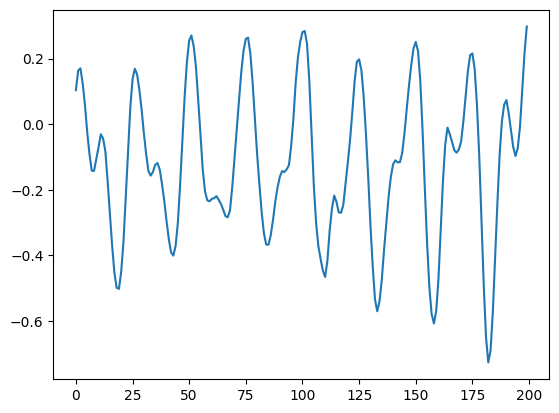

In [59]:
# Visualize a single node variability,
plt.plot(test_wl[:200, 0])
plt.show()

Also the water levels are not normalised.

# Capturing periodicity

In [60]:
train_dt = [datetime(*train_tvec[:, i].astype(int)).timestamp()
    for i in range(train_tvec.shape[1])]

train_ts = np.array(train_dt, dtype=np.float64)

test_dt = [
    datetime(*test_tvec[:, i].astype(int)).timestamp()
    for i in range(test_tvec.shape[1])
]
test_ts = np.array(test_dt, dtype=np.float64)

print("Train time vector shape", train_ts.shape)
print("Test time vector shape", test_ts.shape)
print(train_ts[4])

Train time vector shape (87648,)
Test time vector shape (8784,)
1262318400.0


In [61]:
# creating periodicity from time to give the model access to important frequency features
def freq_set(timestamps):
    day = 24 * 60 * 60
    year = 365.2425 * day

    day_sin  = np.sin(timestamps * (2 * np.pi / day))
    day_cos  = np.cos(timestamps * (2 * np.pi / day))
    year_sin = np.sin(timestamps * (2 * np.pi / year))
    year_cos = np.cos(timestamps * (2 * np.pi / year))

    frequencies = np.column_stack((day_sin, day_cos, year_sin, year_cos))
    print(frequencies.shape)
    return frequencies

train_freq = freq_set(train_ts)
test_freq = freq_set(test_ts)

(87648, 4)
(8784, 4)


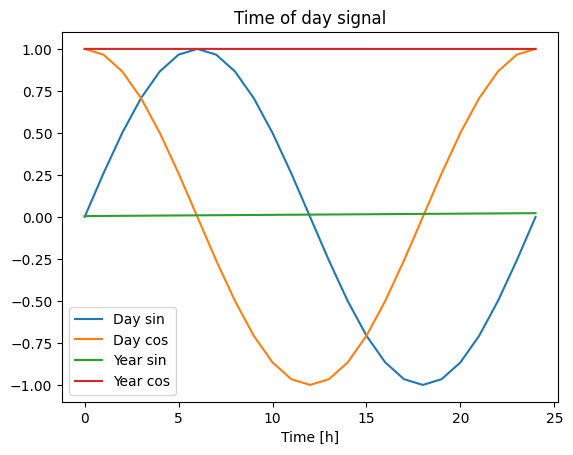

In [62]:
plt.plot(train_freq[:25, 0], label='Day sin')
plt.plot(train_freq[:25, 1], label='Day cos')
plt.plot(train_freq[:25, 2], label='Year sin')
plt.plot(train_freq[:25, 3], label='Year cos')

plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

# Creating train and validation split
Before normalising the era5 and the water level dataset we first fix the split between train, validation and test datasets, to avoid data leakage.

In [63]:
N = train_ts.shape[0]
split_idx = int(N * 0.78)

val_wl    = train_wl[split_idx:]
val_ephem = train_ephem[: , split_idx:]
val_era5  = train_era5[: , split_idx:]
val_ts    = train_ts[split_idx:]
val_freq  = train_freq[split_idx:]
val_dt   = train_dt[split_idx:]

train_wl    = train_wl[:split_idx]
train_ephem = train_ephem[:, :split_idx]
train_era5  = train_era5[:, :split_idx]
train_ts    = train_ts[:split_idx]
train_freq  = train_freq[:split_idx]
train_dt   = train_dt[:split_idx]

print(val_wl.shape, val_ephem.shape, val_era5.shape, val_ts.shape, val_freq.shape)
print(train_wl.shape, train_ephem.shape, train_era5.shape, train_ts.shape, train_freq.shape)

(19283, 5000) (6, 19283) (3, 19283, 5, 9) (19283,) (19283, 4)
(68365, 5000) (6, 68365) (3, 68365, 5, 9) (68365,) (68365, 4)


# Data Normalisation

In [64]:
from sklearn.preprocessing import MinMaxScaler

era5_scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(3)]

In [65]:
train_era5_norm = np.empty_like(train_era5, dtype=float)

for f in range(3):
    x = train_era5[f].reshape(-1, 1)   # (T*C1*C2, 1)
    train_era5_norm[f] = era5_scalers[f].fit_transform(x).reshape(train_era5[f].shape)

In [66]:
train_era5_norm.shape

(3, 68365, 5, 9)

In [67]:
print(train_era5[1,500, :, :])

[[-0.77711487 -0.62672424 -0.43629456 -0.38551331 -0.46363831 -0.55055237
  -0.80738831 -1.07984924 -0.98316956]
 [-0.76930237 -0.83277893 -1.19410706 -1.44508362 -1.50856018 -1.46754456
  -1.50465393 -1.38258362 -1.04664612]
 [-0.87574768 -1.20777893 -1.57008362 -2.07887268 -2.09352112 -2.05250549
  -1.35035706 -1.05641174 -0.71852112]
 [-0.84840393 -1.19801331 -1.63258362 -2.14332581 -2.13160706 -1.65406799
  -0.86109924 -0.74488831 -1.48707581]
 [-0.83570862 -1.20680237 -1.64234924 -2.20289612 -2.18531799 -1.70680237
  -1.07691956 -1.62672424 -2.37379456]]


In [68]:
val_era5_norm = np.empty_like(val_era5, dtype=float)
test_era5_norm = np.empty_like(test_era5, dtype=float)

for f in range(3):
    val_era5_norm[f] = era5_scalers[f].transform(
        val_era5[f].reshape(-1, 1)
    ).reshape(val_era5[f].shape)

    test_era5_norm[f] = era5_scalers[f].transform(
        test_era5[f].reshape(-1, 1)
    ).reshape(test_era5[f].shape)


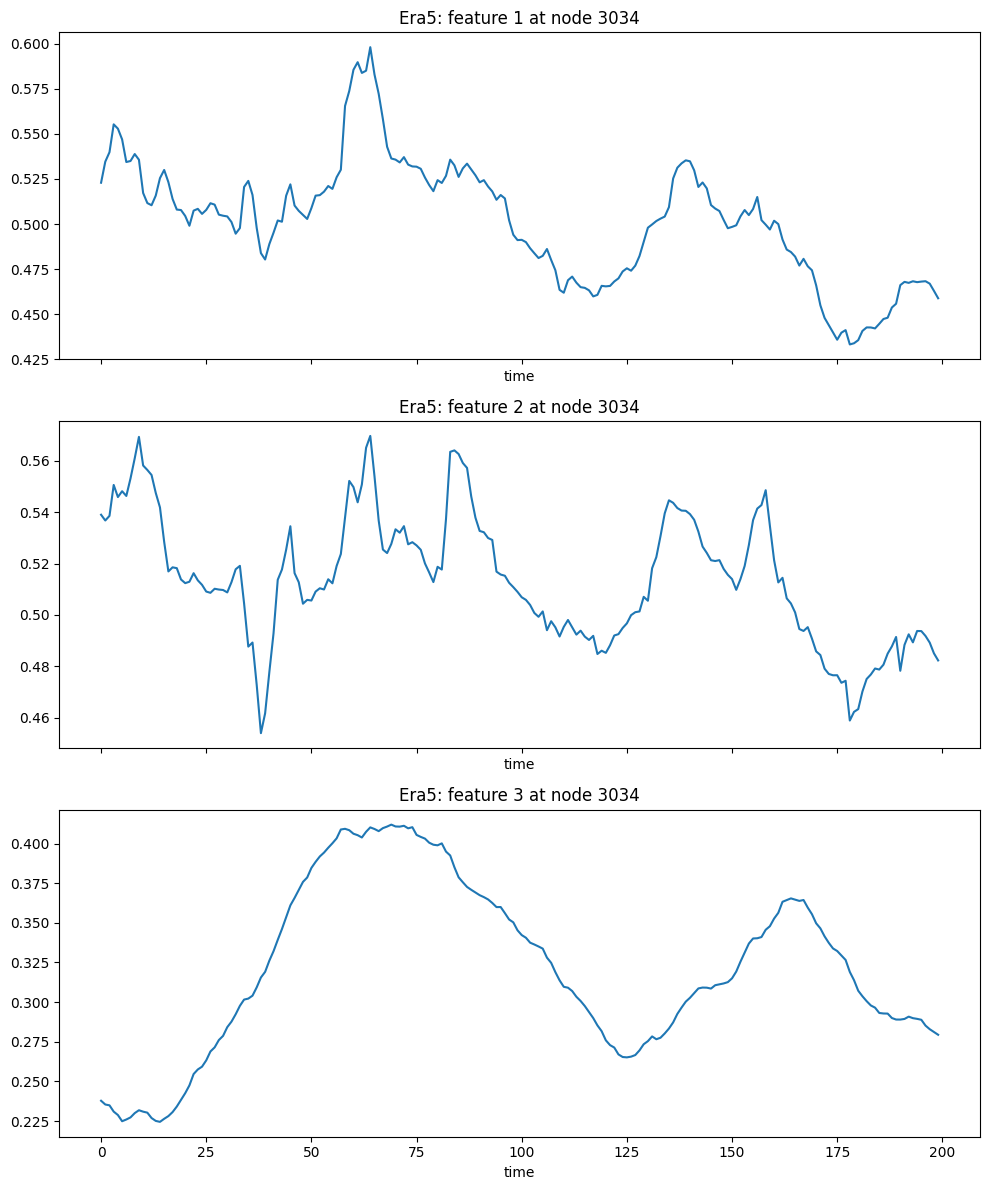

In [69]:
# check that normalisation worked out correctly
node_number = np.random.randint(np.shape(train_wl)[1])
era5_coords = get_era5_coord(lat_vec[node_number], lon_vec[node_number])

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i in range(3):
    axes[i].plot(train_era5_norm[i, :200, era5_coords[0], era5_coords[1]])
    axes[i].set_title(f"Era5: feature {i+1} at node {node_number}")
    axes[i].set_xlabel("time")
plt.tight_layout()
plt.show()

In [70]:
from sklearn.preprocessing import MinMaxScaler

wl_scaler = MinMaxScaler(feature_range=(0, 1))

train_wl_norm = wl_scaler.fit_transform(train_wl)
val_wl_norm   = wl_scaler.transform(val_wl)
test_wl_norm  = wl_scaler.transform(test_wl)


In [71]:
print(train_wl_norm.shape)
print(train_wl.shape)

(68365, 5000)
(68365, 5000)


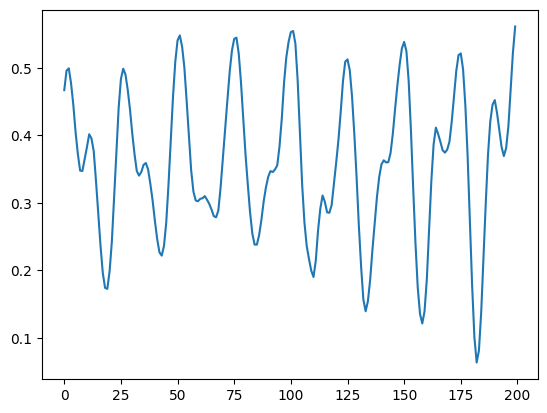

In [72]:
# Visualize a single node variability,
plt.plot(test_wl_norm[:200, 0])
plt.show()

# Grouping datasets

In [73]:
# organising datasets for easier recall during data windowings
train_df = {
    "lat": lat_vec,
    "lon": lon_vec,
    "wl": train_wl_norm,
    "ephem": train_ephem,
    "era5": train_era5_norm,
    "ts": train_ts,
    "freq": train_freq}
val_df = {
    "lat": lat_vec,
    "lon": lon_vec,
    "wl": val_wl_norm,
    "ephem": val_ephem,
    "era5": val_era5_norm,
    "ts": val_ts,
    "freq": val_freq}
test_df = {
    "lat": lat_vec,
    "lon": lon_vec,
    "wl": test_wl_norm,
    "ephem": test_ephem,
    "era5": test_era5_norm,
    "ts": test_ts,
    "freq": test_freq}

# Data Windowing

**WindowGenerator**. This class can:

* Handle indices and offsets as shown in the diagrams above.
* Split feature windows into (features, labels) pairs.
* Plot the contents of the resulting windows.
* Efficiently generate batches of these windows from the training, validation, and test data using `tf.data.Dataset`s.

In [74]:
#TODO split this class definition in multiple cells for better readability

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, batch_size=32,
                 label_columns=None,
                 feature_columns=None,
                 node_ids=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

        self.label_columns = label_columns or ["wl"]
        self.feature_columns = feature_columns or [
            "ephem1", "ephem2", "ephem3", "ephem4", "ephem5",
            "ephem6", "wind0", "wind1", "pressure", "freq1", "freq2", "freq3",
            "freq4"
        ]

        self.node_ids = node_ids
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def _build_inputs_and_labels(self, data):
        T, N = data["wl"].shape

        if self.node_ids is None:
            node_ids = np.arange(N)
        else:
            node_ids = np.array(self.node_ids)

        n_nodes = len(node_ids)

        lat = data["lat"][node_ids]
        lon = data["lon"][node_ids]
        wl = data["wl"][:, node_ids]

        era5_node = np.empty((T, n_nodes, 3), dtype=np.float32)
        for j, node in enumerate(node_ids):
            r, c = get_era5_coord(data["lat"][node], data["lon"][node])
            era5_node[:, j, 0] = data["era5"][0, :, r, c]
            era5_node[:, j, 1] = data["era5"][1, :, r, c]
            era5_node[:, j, 2] = data["era5"][2, :, r, c]

        lat = np.tile(lat[None, :, None], (T, 1, 1))
        lon = np.tile(lon[None, :, None], (T, 1, 1))
        ephem = np.tile(data["ephem"].T[:, None, :], (1, n_nodes, 1))
        freq  = np.tile(data["freq"][:, None, :], (1, n_nodes, 1))

        X = np.concatenate([ephem, era5_node, freq], axis=-1)
        y = wl

        return X.astype(np.float32), y.astype(np.float32)

    def split_window(self, data):
        inputs = data[:, self.input_slice, :, :-1]
        labels = data[:, self.labels_slice, :, -1]

        # Use dynamic shapes (TensorFlow graph-safe)
        shape = tf.shape(inputs)
        B = shape[0]
        T = shape[1]
        N = shape[2]
        F = shape[3]

        inputs = tf.reshape(inputs, (B * N, T, F))
        labels = tf.reshape(labels, (B * N, self.label_width))

        return inputs, labels

    def make_dataset(self, data):
        features, labels = self._build_inputs_and_labels(data)
        data_with_label = np.concatenate([features, labels[..., None]], axis=-1)

        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data_with_label,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,  # IMPORTANT for time series
            batch_size=self.batch_size
        )

        return ds.map(self.split_window)

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_feature_index=0, feature_name=None,
         node_index=0, max_subplots=3):
        """
        plot_feature_index: index of input feature in X (0..F-1)
        node_index: which sample in the batch to plot
        """
        inputs, labels = self.example
        # inputs: (batch_nodes, time, features)
        # labels: (batch_nodes, label_width)

        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, inputs.shape[0])

        for n in range(max_n):
            idx = node_index + n
            if idx >= inputs.shape[0]:
                break

            plt.subplot(max_n, 1, n + 1)

            if feature_name is None:
                feature_name = self.feature_columns[plot_feature_index]

            # plot inputs
            plt.plot(
                self.input_indices,
                inputs[idx, :, plot_feature_index],
                label=feature_name,
                marker=".",
                zorder=-10
            )

            # plot labels
            plt.scatter(
                self.label_indices,
                labels[idx, :],
                edgecolors="k",
                label="Water Level",
                c="#2ca02c",
                s=64
            )

            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[idx, :],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")
        plt.show()

In [75]:
subset_nodes = np.random.choice(5000, size=1, replace=False)

wg = WindowGenerator(
    input_width=48,
    label_width=48,
    shift=1,
    batch_size=16,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    node_ids=subset_nodes,
)

In [76]:
inputs, labels = next(iter(wg.train))
print(inputs.shape)  # (batch, 24, 20, F)
print(labels.shape)  # (batch, 1, 20)

(16, 48, 13)
(16, 48)


Inputs shape: (16, 48, 13)
Labels shape: (16, 48)
Num features: 13
Feature columns: ['ephem1', 'ephem2', 'ephem3', 'ephem4', 'ephem5', 'ephem6', 'wind0', 'wind1', 'pressure', 'freq1', 'freq2', 'freq3', 'freq4']


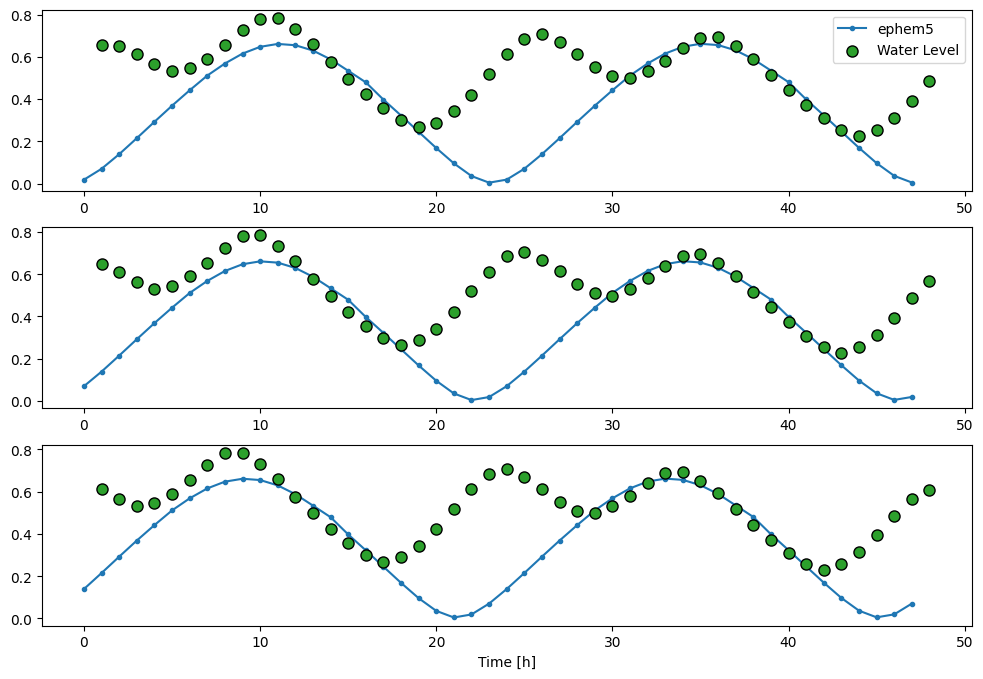

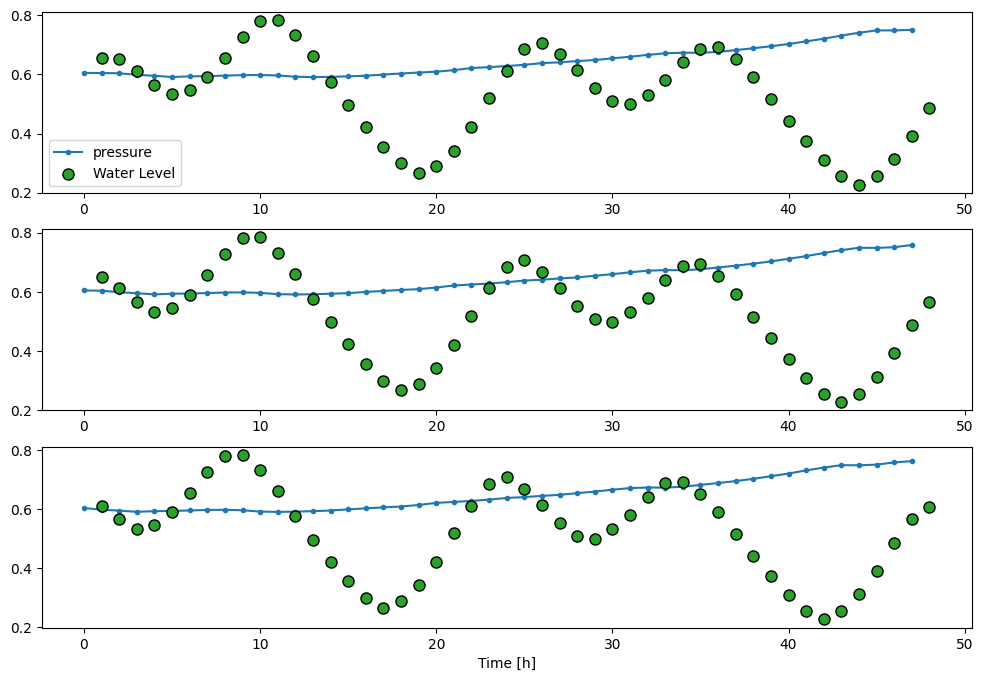

In [77]:
print("Inputs shape:", inputs.shape)  # (batch, 24, 5000, F)
print("Labels shape:", labels.shape)  # (batch, 1, 5000)

# Check input feature dimension
print("Num features:", inputs.shape[-1])
print("Feature columns:", wg.feature_columns)

# Confirm wl not in features
assert "wl" not in wg.feature_columns, "wl should NOT be in inputs"

# plot feature index 0 (lat) for node 0
wg.plot(plot_feature_index=4, node_index=0)

# plot feature index corresponding to pressure
# (lat=0, lon=1, ephem=2..7, era5=8..10, freq=11..14)
# pressure is index 10
wg.plot(plot_feature_index=8, node_index=0)

# Model definition

In [78]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.LSTM(32, return_sequences=True),

    tf.keras.layers.LSTM(16),

    tf.keras.layers.Dense(1),
])

# Model training

In [79]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    restore_best_weights=True,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(3e-4),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Clear overfitting with single_step

In [80]:
subset_nodes = np.random.choice(5000, size=1, replace=False)
wide_window = WindowGenerator(
    input_width=168,
    label_width=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=16,
    shift=1,
    node_ids=subset_nodes)

In [81]:
val_performance = {}
performance = {}

In [82]:
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

performance['LSTM'] = lstm_model.evaluate(wide_window.test, )

Epoch 1/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 114s 25ms/step - loss: 0.0146 - rmse: 0.1185 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 2/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 104s 24ms/step - loss: 0.0067 - rmse: 0.0812 - val_loss: 0.0128 - val_rmse: 0.1130
Epoch 3/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 105s 25ms/step - loss: 0.0054 - rmse: 0.0729 - val_loss: 0.0096 - val_rmse: 0.0980
Epoch 4/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - loss: 0.0048 - rmse: 0.0688 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 5/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 105s 25ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0082 - val_rmse: 0.0907
Epoch 6/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 105s 25ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0076 - val_rmse: 0.0872
Epoch 7/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 105s 25ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0066 - val_rmse: 0.0810
Epoch 8/20
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 106s 25ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0056 - val_rmse: 0.0750


In [83]:
from IPython.display import Audio
# this works only on colab online...
#download audio into the content directory
!wget https://upload.wikimedia.org/wikipedia/commons/b/bd/Bachgasse_Schulglocke_Paganinnni_2021_01.ogg

Audio('/content/Bachgasse_Schulglocke_Paganinnni_2021_01.ogg', autoplay=True)

--2026-02-06 11:11:57--  https://upload.wikimedia.org/wikipedia/commons/b/bd/Bachgasse_Schulglocke_Paganinnni_2021_01.ogg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930320 (909K) [application/ogg]
Saving to: ‘Bachgasse_Schulglocke_Paganinnni_2021_01.ogg’

Bachgasse_Schulgloc 100%[===================>] 908.52K  --.-KB/s    in 0.03s   

2026-02-06 11:11:57 (29.5 MB/s) - ‘Bachgasse_Schulglocke_Paganinnni_2021_01.ogg’ saved [930320/930320]



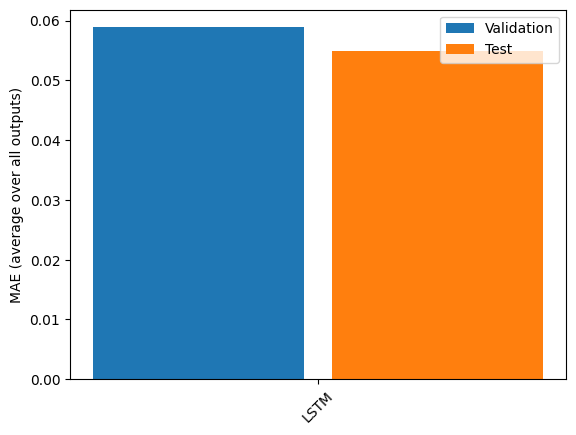

In [84]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'rmse'
metric_index = lstm_model.metrics_names.index('compile_metrics')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [85]:
print(f"persistence baseline: {RMSE(test_wl_norm[:-1],test_wl_norm[1:]):.4f}")

persistence baseline: 0.0461


# Model Evaluation

# Visualing some data

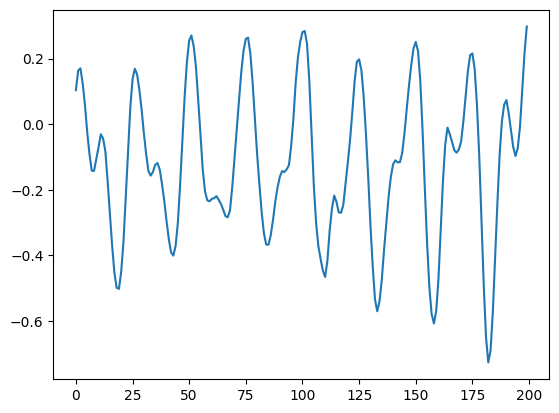

In [86]:
# Visualize a single node variability,
plt.plot(test_wl[:200, 0])
plt.show()

In the picture above you may easily recognize the tydal cycle, with a period of approximately 24 hours.

/usr/local/lib/python3.12/dist-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


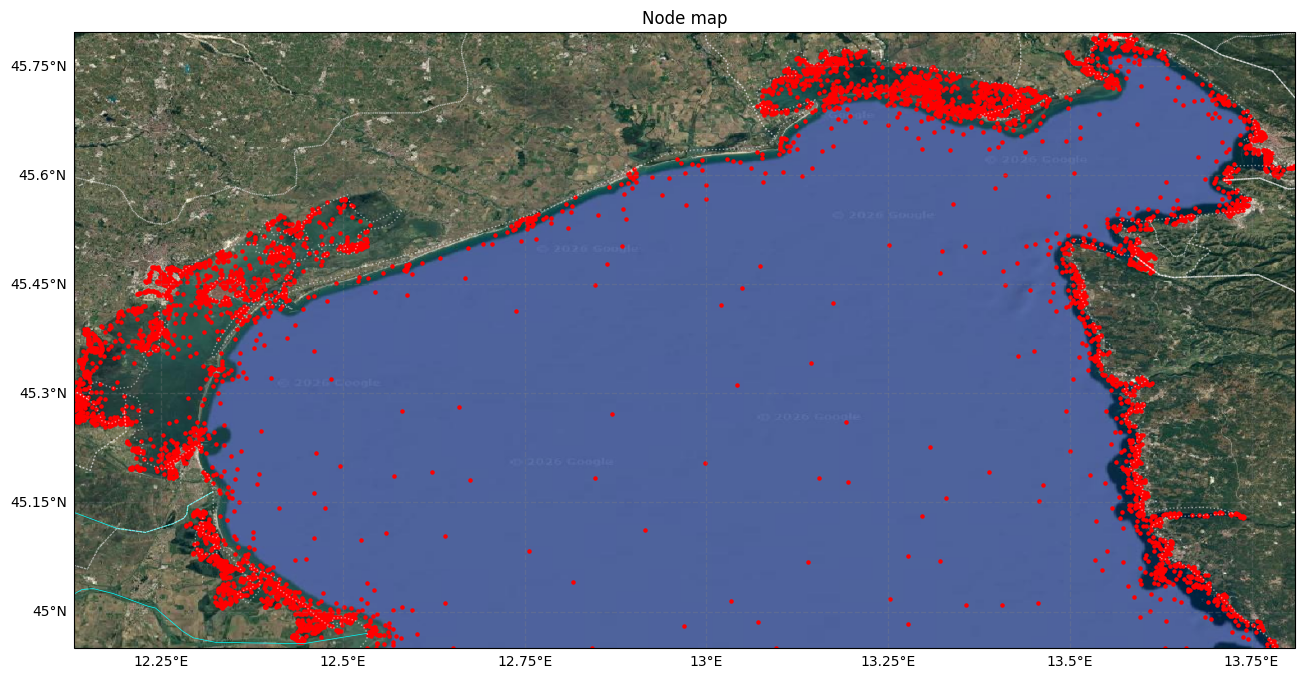

In [87]:
# Create figure and map
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
(lat_min, lat_max), (lon_min, lon_max) = (lat_vec.min(), lat_vec.max()), (lon_vec.min(), lon_vec.max())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

stamen_terrain = cimgt.GoogleTiles(style='satellite')
ax.add_image(stamen_terrain, 10)

ax.add_feature(cfeature.RIVERS, edgecolor='cyan', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='white', alpha=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='white', alpha=0.5)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = gl.right_labels = False

# Plot red dots
# Note: Ensure data is visible against the varied satellite background
sc = ax.scatter(lon_vec, lat_vec, cmap="viridis", c="r", s=5, marker='o', transform=ccrs.PlateCarree(), vmin=0.07, vmax=0.15)
# Increased 's' (size) slightly to make dots visible against satellite texture

plt.title(f'Node map')
plt.savefig("graphical_visualization.png", dpi=400)
plt.show()

# What to deliver

The problem consists in inferring the water level for all nodes in the test set (year 2020).

The solution must be evaluated using RMSE with respect to the given test values.





As an indicative baseline, you may consider persistence, namely using the water level of the previous timestep to predict the current value:

In [88]:
print(f"persistence baseline: {RMSE(test_wl[:-1],test_wl[1:]):.4f}")

persistence baseline: 0.0859


Any marginal improvement w.r.t. the baseline is significant.

As usual, you are supposed to upload a single notebook with your solution, evidence of training, and the final RMSE.

Please note that the model **cannot use** sea levels of previous times steps.